In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as scio
from torch.utils.data import DataLoader, Dataset
import torchmetrics
from PIL import Image
from torchvision import transforms as tfs
import random
import pandas as pd 
from datetime import datetime
from sklearn.neighbors import LocalOutlierFactor as LOF
from sklearn import metrics
from torchvision.transforms import Resize 
#DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
## Preprocess Spectra
yxqdata = scio.loadmat('./ZAV.mat')
X_training_normal= yxqdata['X_training_normal']/7000
X_training = yxqdata['X_training']/7000
X_pre = yxqdata['X_pre']/7000
X_training_normal[X_training_normal<0]=0
X_training[X_training<0]=0
X_pre[X_pre<0]=0
Y_training_normal = (yxqdata['Y_training_normal']).squeeze()
Y_training = (yxqdata['Y_training']).squeeze()
Y_pre = (yxqdata['Y_pre']).squeeze()

#resize
def data_resize(data,a,b):  
    data_1=np.moveaxis(data,-1, 0)  
    data_1 = torch.from_numpy(data_1.astype(np.float32)).unsqueeze(0) 
    torch_resize = Resize([a,b])  
    data_resize = torch_resize(data_1) 
    data_resize=data_resize.squeeze(0)  
    data_resize = data_resize.numpy() 
    data_resize=np.moveaxis(data_resize, 0, -1)  

    return data_resize

## 
X_training_normal=data_resize(X_training_normal,80,120)
X_training=data_resize(X_training,80,120)
X_pre=data_resize(X_pre,80,120)

In [3]:
#define Dataset
class yxqDataset(Dataset):
    def __init__(self, data, labels, transform=None, target_transform=None):
        self.labels = labels
        self.imgs = data
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.imgs[:,:,idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

data_tf = transforms.ToTensor()  
trainset_normal = yxqDataset(X_training_normal, Y_training_normal, transform=data_tf)            
train_normal_loader = DataLoader(trainset_normal, batch_size=16,shuffle=True) 

In [4]:
#define CAE 
class ConvAutoencoder(nn.Module):
    def __init__(self):
            super(ConvAutoencoder, self).__init__()
            #encoder
            self.encoder1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1), 
            nn.ReLU())                                          
            self.max_pool1=nn.MaxPool2d(kernel_size=2,stride=2, return_indices=True)  
            self.encoder2 = nn.Sequential(                       
            nn.Conv2d(16, 32, kernel_size=3,stride=1, padding=0), 
            nn.ReLU())
            self.max_pool2=nn.MaxPool2d(kernel_size=2,stride=2, return_indices=True)  
           
            self.encoder_fc = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(in_features=32*19*29, out_features=120),
            nn.Linear(in_features=120, out_features=32))
         
            #dencoder
            self.dencoder_fc = nn.Sequential(   
            nn.Linear(in_features=32, out_features=120),
            nn.Linear(in_features=120, out_features=32*19*29),
            nn.Unflatten(dim=1,unflattened_size=(32, 19, 29)))
        
            self.maxunpool1=nn.MaxUnpool2d(kernel_size=2,stride=2)
            self.dencoder1 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=0),
            nn.ReLU())
            self.maxunpool2=nn.MaxUnpool2d(kernel_size=2,stride=2)
            self.dencoder2 = nn.Sequential(
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh ())  
            
    def forward(self, x):
            x = self.encoder1(x)
            x,indices1 = self.max_pool1(x)
            x = self.encoder2(x)
            x,indices2 = self.max_pool2(x)
            encoder = self.encoder_fc(x)
            x = self.dencoder_fc(encoder)
            x = self.maxunpool1(x,indices2)
            x = self.dencoder1(x)
            x = self.maxunpool2(x,indices1)
            dencoder = self.dencoder2(x)
            return encoder,dencoder

In [5]:
model = ConvAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
df = pd.DataFrame(columns=['epoch','train_loss'])
df.to_csv('../result/ZAV/loss/ZAV_loss1.csv',index=False)

Epoch 1/100, Training Loss: 0.014803, 
Epoch 2/100, Training Loss: 0.010830, 
Epoch 3/100, Training Loss: 0.008327, 
Epoch 4/100, Training Loss: 0.006740, 
Epoch 5/100, Training Loss: 0.005679, 
Epoch 6/100, Training Loss: 0.004918, 
Epoch 7/100, Training Loss: 0.004341, 
Epoch 8/100, Training Loss: 0.003884, 
Epoch 9/100, Training Loss: 0.003514, 
Epoch 10/100, Training Loss: 0.003208, 
Epoch 11/100, Training Loss: 0.002952, 
Epoch 12/100, Training Loss: 0.002735, 
Epoch 13/100, Training Loss: 0.002548, 
Epoch 14/100, Training Loss: 0.002385, 
Epoch 15/100, Training Loss: 0.002242, 
Epoch 16/100, Training Loss: 0.002116, 
Epoch 17/100, Training Loss: 0.002004, 
Epoch 18/100, Training Loss: 0.001903, 
Epoch 19/100, Training Loss: 0.001812, 
Epoch 20/100, Training Loss: 0.001730, 
Epoch 21/100, Training Loss: 0.001655, 
Epoch 22/100, Training Loss: 0.001586, 
Epoch 23/100, Training Loss: 0.001523, 
Epoch 24/100, Training Loss: 0.001466, 
Epoch 25/100, Training Loss: 0.001413, 
Epoch 26/

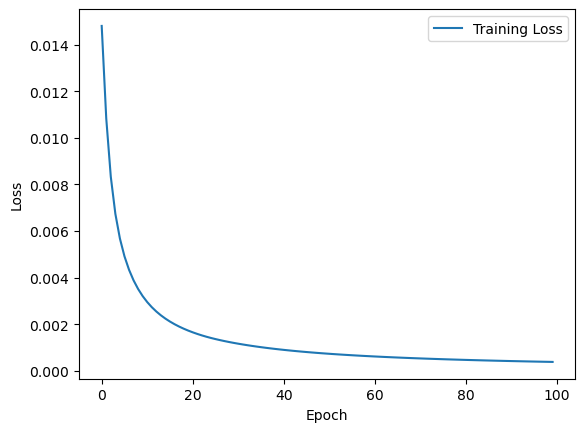

In [6]:
train_losses=[] 
list=[]
train_num = 0
train_loss_epoch=0
num_epochs = 100 
for epoch in range(num_epochs):
    train_loss = 0.0
    model.train() 
    for data in train_normal_loader:
        img, _ = data
        img=img.to(torch.float32)
        train_recon,train_recon2 = model(img)   
        train_recon2=train_recon2.to(torch.float32)
        loss = criterion(train_recon2, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_epoch += loss.item() * img.size(0)
        train_num = train_num + img.size(0)
        train_loss = train_loss_epoch / train_num
    
    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Training Loss: {train_loss:.6f}, ')
    list = [epoch+1,train_loss]
    data = pd.DataFrame([list])
    data.to_csv('../result/ZAV/loss/ZAV_loss1.csv',mode='a',header=False,index=False)  
    train_losses.append(train_loss)

plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

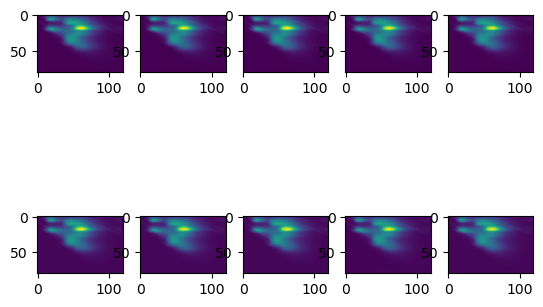

In [14]:
#  show input image and reconstructed image
n=5
fig = plt.figure()
for i in range(n):
    plt.subplot(2,n,i+1) 
    imgs = trainset_normal[i][0].unsqueeze(0) 
    plt.imshow(imgs.squeeze().numpy())  
    with torch.no_grad():
        imgs=imgs.to(torch.float32)
        output_1, output_2 = model(imgs)  
        plt.subplot(2, n, i + 1 + n)        
        output_2=output_2.view(1,80,120) 
        plt.imshow(output_2.squeeze().numpy()) 


In [15]:
#torch.save(model.state_dict(), './model_CU_1'))

In [13]:
#load model
model.load_state_dict(torch.load('./model_ZAV.pt'))

# Dataloader
training_normal_loader = DataLoader(trainset_normal,shuffle=False) 
trainset = yxqDataset(X_training, Y_training, transform=data_tf)                
training_loader = DataLoader(trainset,shuffle=False) 
preset = yxqDataset(X_pre, Y_pre, transform=data_tf)                
pre_loader = DataLoader(preset,shuffle=False) 

In [14]:
def CAE(loader):
    recon_list=[]
    recon2_list=[]
    loss_list=[]
    labels_list=[]
    model.eval()  
    for i, data in enumerate(loader):
        img, labels = data
        img=img.to(torch.float32)
        recon,recon2 = model(img)
        loss = criterion(recon2, img)
        loss_list.append(loss.item())
        recon_list.extend(recon.to('cpu').detach().numpy()) 
        recon2_list.extend(recon2.to('cpu').detach().numpy())
        labels_list.extend(labels.to('cpu').numpy())
    
    labels=np.array(labels_list) 
    loss=np.array(loss_list)
    recon=np.array(recon_list)
    recon2_list = torch.tensor(recon2_list) 
    k=np.size(recon2_list,0) 
    recon2_list=recon2_list.view(1*k,80,120)
    recon2_list =recon2_list.detach().numpy()
    
    return labels,loss,recon,recon2_list

In [15]:
#reconstruction loss and hide layer data on training normal set
training_normal_label,training_normal_loss,training_normal_recon,training_normal_recon2=CAE(training_normal_loader)

<AxesSubplot:>

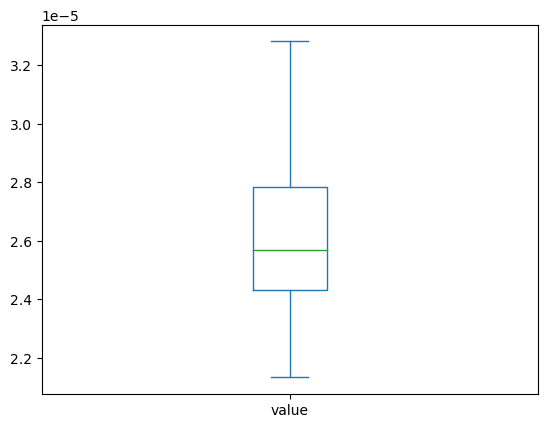

In [16]:
#Boxplot 
def box_outlier(df,label):  
    Q1 = df.quantile(q=0.25)  
    Q3 = df.quantile(q=0.75)  
    
    up_whisker=Q3+1.5*(Q3-Q1) 
    low_whisker=Q1-1.5*(Q3 - Q1) 
    
    kk = df[(df > up_whisker) | (df < low_whisker)]
    data = pd.DataFrame({'id': kk.index, 'Outlier': kk,'label':label[kk.index]})

    return data,Q1,Q3,up_whisker,low_whisker,kk,kk.index

df = pd.DataFrame(training_normal_loss, columns= ['value'])
df= df.iloc[:,0]  
result,Q1,Q3,up_whisker,low_whisker,kk,kk.index = box_outlier(df,training_normal_label)

import matplotlib.pyplot as plt
fig,axes = plt.subplots()
df.plot(kind='box',ax=axes)

In [17]:
#LOF model
from pyod.models.lof import LOF
clf_name = 'LOF'
clf = LOF(contamination = 0.01) 
clf.fit(training_normal_recon)
training_normal_pred = clf.predict(training_normal_recon)  

print("confusion_matrix:\n", metrics.confusion_matrix(training_normal_label,training_normal_pred))

confusion_matrix:
 [[175]]


In [18]:
# obtained the reconstruction loss and hide layer data on training and pre set
training_label,training_loss,training_recon,training_recon2=CAE(training_loader)
pre_label,pre_loss,pre_recon,pre_recon2=CAE(pre_loader)

In [19]:
#define the OCC_CAE classify based on box and lof 
def OCC_CAE_class(label,loss,recon,up_whisker,training_normal_recon):
    loss_index_abnormal_1=np.flatnonzero(loss>up_whisker)
    k=len(label) 
    Boxplot_prelabel = np.zeros(k)
    Boxplot_prelabel[loss_index_abnormal_1] = 1
    
    clf = LOF(contamination = 0.01)
    clf.fit(training_normal_recon)
    LOF_prelabel = clf.predict(recon) 
    
    OC_CAE_prelabel=Boxplot_prelabel+LOF_prelabel
    OC_CAE_prelabel_abnormal_index=np.flatnonzero(OC_CAE_prelabel > 0 )
    OC_CAE_prelabel_normal_index=np.flatnonzero(OC_CAE_prelabel == 0 )
    
    OC_CAE_prelabel[OC_CAE_prelabel_abnormal_index]=1
    OC_CAE_prelabel[OC_CAE_prelabel_normal_index]=0
    
    return label,Boxplot_prelabel,LOF_prelabel,OC_CAE_prelabel

In [20]:
label_training,Boxplot_training,LOF_training,OC_CAE_training=OCC_CAE_class(training_label,training_loss,training_recon,up_whisker,training_normal_recon)
print("Training Set Classification:")
print("Boxplot confusion_matrix:\n", metrics.confusion_matrix(label_training,Boxplot_training))
print("LOF confusion_matrix:\n", metrics.confusion_matrix(label_training,LOF_training))
print("OC_CAE confusion_matrix:\n", metrics.confusion_matrix(label_training,OC_CAE_training))
tp, fn, fp, tn = metrics.confusion_matrix(label_training,OC_CAE_training).ravel()
print("tp: {}, fn: {}, fp: {}, tn: {}".format(tp, fn, fp, tn)) 
Specificity = tn / (tn + fp)  
print('Accuracy:',metrics.accuracy_score(label_training,OC_CAE_training))
print('Specificity（特异性）：',Specificity)

Training Set Classification:
Boxplot confusion_matrix:
 [[35  0]
 [ 0 70]]
LOF confusion_matrix:
 [[35  0]
 [ 0 70]]
OC_CAE confusion_matrix:
 [[35  0]
 [ 0 70]]
tp: 35, fn: 0, fp: 0, tn: 70
Accuracy: 1.0
Specificity（特异性）： 1.0


In [21]:
label_pre,Boxplot_pre,LOF_pre,OC_CAE_pre=OCC_CAE_class(pre_label,pre_loss,pre_recon,up_whisker,training_normal_recon)
print("Prediction Set Classification:")
print("Boxplot confusion_matrix:\n", metrics.confusion_matrix(label_pre,Boxplot_pre))
print("LOF confusion_matrix:\n", metrics.confusion_matrix(label_pre,LOF_pre))
print("OC_CAE confusion_matrix:\n", metrics.confusion_matrix(label_pre,OC_CAE_pre))
tp, fn, fp, tn = metrics.confusion_matrix(label_pre,OC_CAE_pre).ravel()
print("tp: {}, fn: {}, fp: {}, tn: {}".format(tp, fn, fp, tn)) 
Specificity = tn / (tn + fp)  
print('Accuracy:',metrics.accuracy_score(label_pre,OC_CAE_pre))
print('Specificity（特异性）：',Specificity)

Prediction Set Classification:
Boxplot confusion_matrix:
 [[14  1]
 [ 0 30]]
LOF confusion_matrix:
 [[15  0]
 [ 0 30]]
OC_CAE confusion_matrix:
 [[14  1]
 [ 0 30]]
tp: 14, fn: 1, fp: 0, tn: 30
Accuracy: 0.9777777777777777
Specificity（特异性）： 1.0


In [22]:
# reshape data
k_training_normal=np.size(X_training_normal,2)
X_training_normal_reshape=X_training_normal.transpose(2, 0, 1) 
X_training_normal_reshape=X_training_normal_reshape.reshape(k_training_normal,9600)  

k_training=np.size(X_training,2)
X_training_reshape=X_training.transpose(2, 0, 1) 
X_training_reshape=X_training_reshape.reshape(k_training,9600) 

k_pre=np.size(X_pre,2)
X_pre_reshape=X_pre.transpose(2, 0, 1) 
X_pre_reshape=X_pre_reshape.reshape(k_pre,9600)  


In [23]:
#Boxplot
def dist(X):
    sample=np.size(X,0)
    dist_list=[]
    for i in range(sample):
        data=X[i,:]
        sum=0
        for j in range(9600):
            sum+=data[j]**2
            dist = np.sqrt(sum)
        dist_list.append(dist.item())
    dist_list =torch.tensor(dist_list)
    return dist_list

##
dist_training_normal=dist(X_training_normal_reshape)
dist_training=dist(X_training_reshape)
dist_pre=dist(X_pre_reshape)

##
df = pd.DataFrame(dist_training_normal, columns= ['value'])
df= df.iloc[:,0]  
result,Q1,Q3,up_whisker,low_whisker,kk,kk.index = box_outlier(df,Y_training_normal)

##
def dist_boxclass(dist,label,up_whisker,low_whisker):
    dist_index_abnormal_1=np.flatnonzero(dist<low_whisker) 
    dist_index_abnormal_2=np.flatnonzero(dist>up_whisker)  
    k=len(label)
    dist_prelabel = np.zeros(k)
    dist_prelabel[dist_index_abnormal_1] = 1
    dist_prelabel[dist_index_abnormal_2] = 1
    return dist_prelabel

##
dist_trainlabel=dist_boxclass(dist_training,Y_training,up_whisker,low_whisker)
print('Classification results of Training Set:')
print("confusion_matrix:\n", metrics.confusion_matrix(Y_training,dist_trainlabel))
tp, fn, fp, tn = metrics.confusion_matrix(Y_training,dist_trainlabel).ravel()
print("tp: {}, fn: {}, fp: {}, tn: {}".format(tp, fn, fp, tn)) 
Specificity = tn / (tn + fp)  
print('Accuracy:',metrics.accuracy_score(Y_training,dist_trainlabel))
print('Specificity（特异性）：',Specificity)
print('')
dist_prelabel=dist_boxclass(dist_pre,Y_pre,up_whisker,low_whisker)
print('Classification results of Prediction Set:')
print("confusion_matrix:\n", metrics.confusion_matrix(Y_pre,dist_prelabel))
tp, fn, fp, tn = metrics.confusion_matrix(Y_pre,dist_prelabel).ravel()
print("tp: {}, fn: {}, fp: {}, tn: {}".format(tp, fn, fp, tn)) 
Specificity = tn / (tn + fp)  
print('Accuracy:',metrics.accuracy_score(Y_pre,dist_prelabel))
print('Specificity（特异性）：',Specificity)

Classification results of Training Set:
confusion_matrix:
 [[35  0]
 [26 44]]
tp: 35, fn: 0, fp: 26, tn: 44
Accuracy: 0.7523809523809524
Specificity（特异性）： 0.6285714285714286

Classification results of Prediction Set:
confusion_matrix:
 [[15  0]
 [16 14]]
tp: 15, fn: 0, fp: 16, tn: 14
Accuracy: 0.6444444444444445
Specificity（特异性）： 0.4666666666666667


In [24]:
#LOF algorithm
from pyod.models.lof import LOF
clf_name = 'LOF'
clf = LOF(contamination = 0.01) 
clf.fit(X_training_normal_reshape)

lof_trainlabel = clf.predict(X_training_reshape)
print('Classification results of Training Set:')
print("confusion_matrix:\n", metrics.confusion_matrix(Y_training,lof_trainlabel))
tp, fn, fp, tn = metrics.confusion_matrix(Y_training,lof_trainlabel).ravel()
print("tp: {}, fn: {}, fp: {}, tn: {}".format(tp, fn, fp, tn)) 
Specificity = tn / (tn + fp)  
print('Accuracy:',metrics.accuracy_score(Y_training,lof_trainlabel))
print('Specificity（特异性）：',Specificity)
print('')

lof_prelabel = clf.predict(X_pre_reshape)
print('Classification results of Prediction Set:')
print("confusion_matrix:\n", metrics.confusion_matrix(Y_pre,lof_prelabel))
tp, fn, fp, tn = metrics.confusion_matrix(Y_pre,lof_prelabel).ravel()
print("tp: {}, fn: {}, fp: {}, tn: {}".format(tp, fn, fp, tn)) 
Specificity = tn / (tn + fp)  
print('Accuracy:',metrics.accuracy_score(Y_pre,lof_prelabel))
print('Specificity（特异性）：',Specificity)

Classification results of Training Set:
confusion_matrix:
 [[35  0]
 [ 0 70]]
tp: 35, fn: 0, fp: 0, tn: 70
Accuracy: 1.0
Specificity（特异性）： 1.0

Classification results of Prediction Set:
confusion_matrix:
 [[15  0]
 [ 0 30]]
tp: 15, fn: 0, fp: 0, tn: 30
Accuracy: 1.0
Specificity（特异性）： 1.0


In [25]:
#OC_SVM
gammas = np.logspace(-4, 2, 7)
nus = np.linspace(0.01, 0.99, 99)
from sklearn.svm import OneClassSVM
##  grid search start
best_score=0
clf = OneClassSVM()
results = []
results_2=[]
for gamma in gammas:
    for nu in nus:
        clf.set_params(kernel='rbf',gamma=gamma, nu=nu)
        clf.fit(X_training_normal_reshape)
        y_training = clf.predict(X_training_reshape)
        y_training_normal=np.flatnonzero(y_training == 1)
        y_training_abnormal=np.flatnonzero(y_training == -1)
        y_training[y_training_normal]=0
        y_training[y_training_abnormal]=1
        y_training_score=metrics.accuracy_score(Y_training, y_training)
        y_pre = clf.predict(X_pre_reshape)
        y_pre_normal=np.flatnonzero(y_pre  == 1)
        y_pre_abnormal=np.flatnonzero(y_pre  == -1)
        y_pre[y_pre_normal]=0
        y_pre[y_pre_abnormal]=1
        y_pre_score=metrics.accuracy_score(Y_pre, y_pre)
        score=y_training_score+y_pre_score 
        if score > best_score:#find the optimized parameter;
            best_score = score
            best_parameters = {'gamma':gamma,'nu':nu}
            score_results={'Training_score':y_training_score,'Test_score':y_pre_score}
#  grid search end
print("Best score:{:.2f}".format(best_score))
print("Score:{}".format(score_results))
print("Best parameters:{}".format(best_parameters))

###
model_1 = OneClassSVM(kernel='rbf', nu=0.04, gamma=0.1)
model_1.fit(X_training_normal_reshape)

##
def OneSVM_class(X_reshape):
    OneSVM_normal = model_1.predict(X_reshape)   
    OneSVM_normal_index=np.flatnonzero(OneSVM_normal == 1)
    OneSVM_abnormal_index=np.flatnonzero(OneSVM_normal == -1)
    OneSVM_normal[OneSVM_normal_index]=0
    OneSVM_normal[OneSVM_abnormal_index]=1
    return OneSVM_normal

##
OneSVM_training_label=OneSVM_class(X_training_reshape)
print('Classification results of Training Set')
print("confusion_matrix:\n", metrics.confusion_matrix(Y_training,OneSVM_training_label))
tp, fn, fp, tn = metrics.confusion_matrix(Y_training,OneSVM_training_label).ravel()
print("tp: {}, fn: {}, fp: {}, tn: {}".format(tp, fn, fp, tn)) 
Specificity = tn / (tn + fp)  
print('Accuracy:',metrics.accuracy_score(Y_training,OneSVM_training_label))
print('Specificity（特异性）：',Specificity)
print('')

OneSVM_pre_label=OneSVM_class(X_pre_reshape)
print('Classification results of Prediction Set')
print("confusion_matrix:\n", metrics.confusion_matrix(Y_pre,OneSVM_pre_label))
tp, fn, fp, tn = metrics.confusion_matrix(Y_pre,OneSVM_pre_label).ravel()
print("tp: {}, fn: {}, fp: {}, tn: {}".format(tp, fn, fp, tn)) 
Specificity = tn / (tn + fp)  
print('Accuracy:',metrics.accuracy_score(Y_pre,OneSVM_pre_label))
print('Specificity（特异性）：',Specificity)


Best score:1.96
Score:{'Training_score': 1.0, 'Test_score': 0.9555555555555556}
Best parameters:{'gamma': 0.1, 'nu': 0.04}
Classification results of Training Set
confusion_matrix:
 [[35  0]
 [ 0 70]]
tp: 35, fn: 0, fp: 0, tn: 70
Accuracy: 1.0
Specificity（特异性）： 1.0

Classification results of Prediction Set
confusion_matrix:
 [[13  2]
 [ 0 30]]
tp: 13, fn: 2, fp: 0, tn: 30
Accuracy: 0.9555555555555556
Specificity（特异性）： 1.0
